# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [1]:
!pip install pretrainedmodels

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

# PATH = "/Users/helen/Desktop/Data/bengaliai-cv19/"
# FEATHER_PATH = "/Users/helen/Desktop/Data/bengaliaicv19feather/"

# PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/"
# FEATHER_PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliaicv19feather/"

PATH = "/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/"
FEATHER_PATH = "/home/vemlr/Work/chen_huang/Data/bengaliaicv19feather/"

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_0.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/class_map.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_1.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_3.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_3.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_1.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/sample_submission.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_2.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_2.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_0.parquet


In [4]:
import torch

debug = False
submission=False
batch_size=96
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out='.'
image_size= 128
arch='pretrained'
model_name='se_resnext50_32x4d'

In [5]:
datadir = Path(PATH)
featherdir = Path(FEATHER_PATH)
outdir = Path('kfold_res_aug')

In [6]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [7]:
import cv2
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=image_size, pad=3, thh = 80, thl = 28):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > thh)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < thl] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))


In [8]:
import numpy as np
import pandas as pd
import gc

HEIGHT = 137
WIDTH = 236

def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype('uint8') for df in image_df_list]

#     images = []
#     for df in image_df_list:
#         for idx in tqdm(range(len(df))):
#             images.append(crop_resize(df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype('uint8')))
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [9]:
%%time

# train = pd.read_csv(datadir/'train.csv')
train = pd.read_csv('train_with_fold.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0,1,2,3] #if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)

image_df_list 4
CPU times: user 32.1 s, sys: 29.4 s, total: 1min 1s
Wall time: 6.65 s


In [10]:
print(len(train_labels))
print(len(train))
print(train_labels[200840-1])

200840
200840
[127   2   0]


In [11]:
 import sys 

# These are the usual ipython objects, including this one you are creating 
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars'] 

# Get a sorted list of the objects and their sizes 
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True) 

[('train_images', 6493559008),
 ('train', 39643864),
 ('HTML', 1064),
 ('KFold', 1064),
 ('Path', 896),
 ('filenames', 200),
 ('bbox', 144),
 ('crop_resize', 144),
 ('display', 144),
 ('prepare_image', 144),
 ('datadir', 120),
 ('featherdir', 120),
 ('outdir', 120),
 ('train_labels', 112),
 ('indices', 104),
 ('FEATHER_PATH', 103),
 ('PATH', 97),
 ('dirname', 97),
 ('cb', 88),
 ('ff', 88),
 ('go', 88),
 ('lgb', 88),
 ('np', 88),
 ('pd', 88),
 ('plt', 88),
 ('preprocessing', 88),
 ('px', 88),
 ('sns', 88),
 ('subplots', 88),
 ('tools', 88),
 ('xgb', 88),
 ('filename', 75),
 ('model_name', 67),
 ('arch', 59),
 ('out', 50),
 ('HEIGHT', 28),
 ('WIDTH', 28),
 ('batch_size', 28),
 ('image_size', 28),
 ('debug', 24),
 ('device', 24),
 ('submission', 24)]

<a id="dataset"></a>
# Dataset

In [12]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [13]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

In [14]:
train_dataset_noaug = BengaliAIDataset(train_images[:200], train_labels)

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [15]:
image, label = train_dataset_noaug[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


In [16]:
# print(image[:5,:5])
# print(20/255)

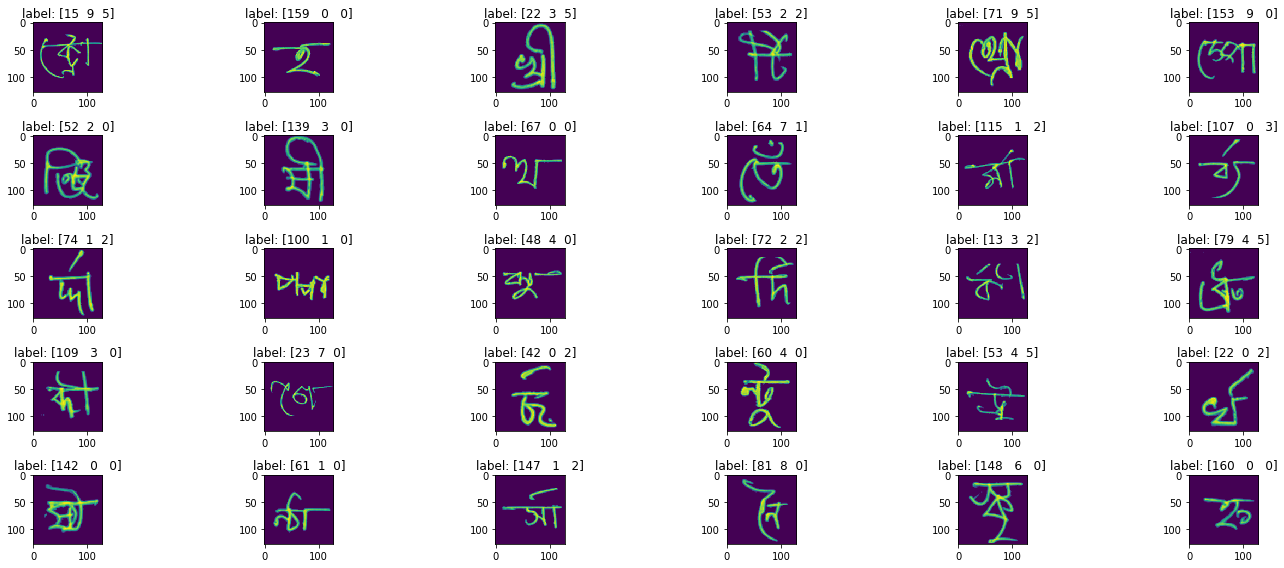

<Figure size 432x288 with 0 Axes>

In [17]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_resize(image, thh = 80.0/255, thl=28.0/255)) #, cmap='Greys'
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [18]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import SimilarityTransform, AffineTransform, warp
import numpy as np
import math


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 20
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle)*np.pi/180.0

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle)*np.pi/180.0

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)
    
#     print("rot:{}, shear:{},tx:{},ty:{}".format(rot_angle,shear_angle, tx,ty))
    
    shape = img.shape
    shape_size = shape[:2]
    center = np.float32(shape_size) / 2.
        
    pre = SimilarityTransform(translation=-center)
    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle, translation=(tx,ty)) 
    after = AffineTransform(translation=center)
    total_transform = pre+tform+after
#     total_transform = tform
    transformed_image = warp(img, total_transform.params, mode='constant')
    
    assert transformed_image.ndim == 2
    return transformed_image

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_char_image_thin(image, threshold=40./255., pad = 16):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

def crop_char_image(img0, threshold=80./255., pad=10):
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > threshold)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28./255.] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return img

def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

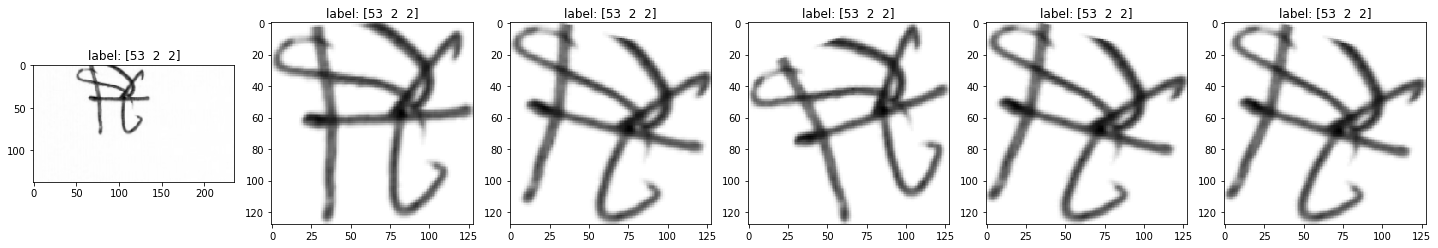

In [19]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[3]
    if i ==0:
        ax.imshow(image, cmap='Greys')
    else:
        ax.imshow(resize(crop_char_image_thin(affine_image(crop_resize(image, thh = 80.0/255, thl=28.0/255, pad=16)))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
# crop_resize(image, thh = 80.0/255, thl=28.0/255, pad=16)

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

## crop image

Here I crop image

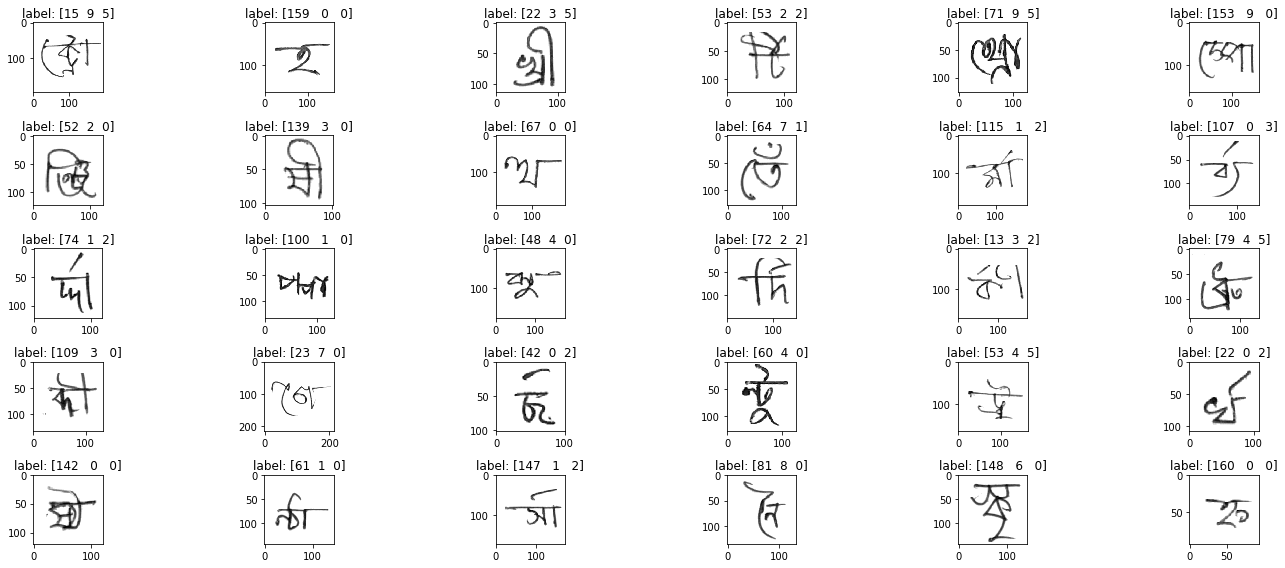

In [20]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_char_image(image, threshold=80./255.), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

## resize image

We need to resize image after crop, to align image size for CNN batch training.

whole process: crop_Char_imgage->affine->crop_char_image_thin->resize

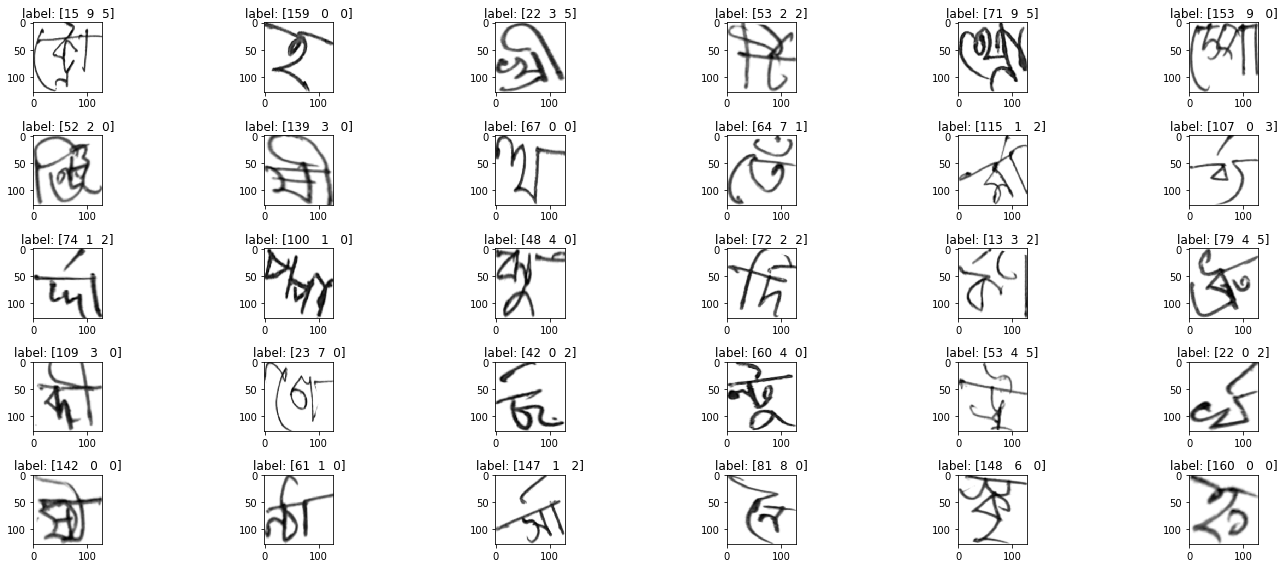

In [21]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(resize(crop_char_image_thin(affine_image((crop_char_image(image, threshold=100./255.))))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [22]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']

TH = 80.0

class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=TH,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
            
        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
            
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)
            
        if self.crop:
            x = crop_char_image_thin(x, threshold=self.threshold/2)        
            
        if self.size is not None:
            x = resize(x, size=self.size)
            


        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
#            x = apply_aug(A.Cutout(num_holes=1,  max_h_size=16, max_w_size=16, p=1.0),x)  # Deprecated...
             x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0, mode='constant'), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=20,
                p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if self.normalize:
            x = (x.astype(np.float32) - 0.0692) / 0.2051
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [23]:
train_transform = Transform(
    size=(image_size, image_size), 
    sigma=-1., blur_ratio=0.2, noise_ratio=0.1, cutout_ratio=0.5,
    grid_distortion_ratio=0.1, random_brightness_ratio=0.2,
    piece_affine_ratio=0.1, ssr_ratio=0.2, elastic_distortion_ratio=0.1) #threshold=20.,
# transform = Transform(size=(image_size, image_size)
train_dataset = BengaliAIDataset(train_images[:200], train_labels,
                                 transform=train_transform)

By setting `transform`, its function is called **every time** when we access to the index. Dataset returns different `image` every time! which is useful for training with data augmentation.

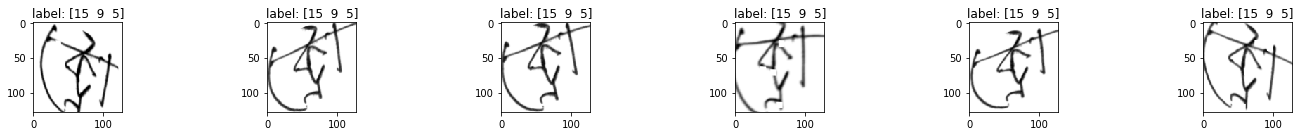

In [24]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 2))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[0]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Let's final check the processed images, which will be trained by the model.

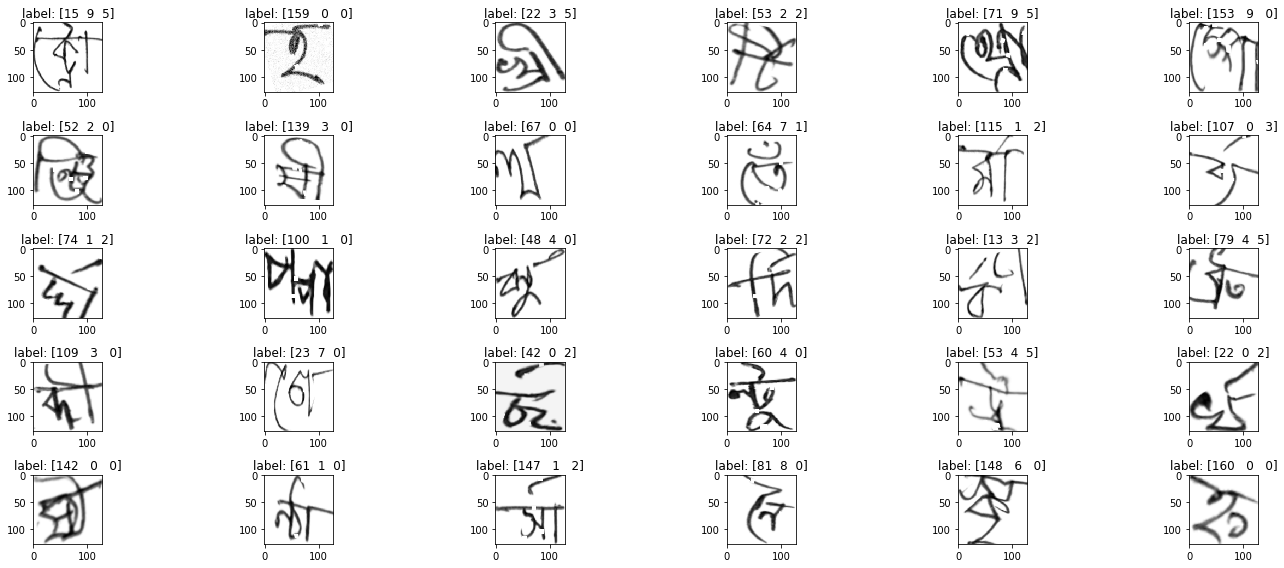

In [25]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [26]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [27]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [28]:
a = np.array([2,3])
b = np.array([4,5,6])

In [29]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [30]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [31]:
a = torch.Tensor([[1,2],[3,4]])
b = torch.sum(a,dim=(-1,-2))
print(b)

tensor(10.)


In [32]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential


class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext101_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet'):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        h = self.conv0(x)
        h = self.base_model.features(h)

        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        for layer in self.lin_layers:
            h = layer(h)
        return h

## Classifier

In [33]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    if isinstance(acc, torch.Tensor):
        acc = acc.item()
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

    def forward(self, x, y=None):
        pred = self.predictor(x)
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels


<a id="train"></a>
# Training code


In [34]:
# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)

def schedule_lr(metrics):
    avg_mae = metrics['loss']
    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

n_total 186


## prepare data

In [35]:
from logging import getLogger
import numpy
import os
from time import perf_counter
import argparse
from distutils.util import strtobool
import torch
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

import pandas as pd
import torch
import json


def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


In [36]:
class LogReport:
    def __init__(self, dirpath=None, logger=None):
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, epoch, iteration, train_metrics, val_metrics, mode):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': epoch,
                'iteration': iteration}
        
        elem.update({f'train/{key}': value
                     for key, value in train_metrics.items()})
        
        elem.update({f'val/{key}': value
             for key, value in val_metrics.items()})
        
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
#         print("mode in log type:{}, val:{}".format(type(mode), mode))
        elem['mode'] = str(mode)
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            elif isinstance(value, str):
                msg += f'{key} {value} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df

In [37]:
class ModelSnapshotHandler:
    def __init__(self, model, filepath='model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self):
        self.count += 1
        filepath = self.filepath.format(count=self.count)
        torch.save(self.model.state_dict(), filepath)

In [38]:
import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score

In [39]:
loss_recall_names =  ['loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant', 'recall']

In [40]:
def train_model(epoch, data_loader, log_report, n_train_call):
    classifier.train()
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    n_tag = 0
    for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
        n_sub = img_batch.shape[0]
        img_batch = img_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        loss, metrics, pred_y = classifier(img_batch, regr_batch)
        
        recall = macro_recall(pred_y, regr_batch)
        metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
        for key, val in metrics.items():
                metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)
                
        n_tag = n_tag + n_sub
        n_train_call[0] += n_sub
        
        loss.backward()
        optimizer.step()
        
    schedule_lr(metrics_total)
    return metrics_total, n_train_call

In [41]:
def evaluate_model(epoch, data_loader, log_report):
    classifier.eval()
    n_tag = 0
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    with torch.no_grad():
        for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
            n_sub = img_batch.shape[0]
            img_batch = img_batch.to(device)
            regr_batch = regr_batch.to(device)

            _, metrics, pred_y = classifier(img_batch, regr_batch)
        
            recall = macro_recall(pred_y, regr_batch)
            metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
            for key, val in metrics.items():
                    metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)

            n_tag = n_tag + n_sub
    
        return metrics_total


## Train


In [42]:
def save_res(predictor, l1, epoch, val_metrics, min_val_loss, max_val_recall, outdir):
    mode = list("000")
    if((epoch+1)%10==0):
        model_file_name = os.path.join(outdir, 'predictor_{}_{}.pt'.format(l1,epoch))
        torch.save(predictor.state_dict(), model_file_name)
        mode[0] = "1"
    if(val_metrics['loss']<min_val_loss):
        min_val_loss = val_metrics['loss']
        if mode[0] is "0":
            model_file_name = os.path.join(outdir, 'predictor_min_loss.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[1] = "1"
    if(val_metrics['recall']>max_val_recall):
        max_val_recall = val_metrics['recall']
        if mode[0] is not "1" and mode[1] is not "1":
            model_file_name = os.path.join(outdir, 'predictor_max_recall.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[2] = "1"
    mode = ''.join(mode)
    return mode, min_val_loss, max_val_recall

In [43]:
# mode = list("000")
# mode = ''.join(mode)
# print(mode)
# msg = ''
# key ="mode"
# value = mode
# msg += f'{key} {value}' 
# print(msg)

In [44]:
# import gc

# train_labels_total = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
# n_epochs = 50
# log_report = LogReport(dirpath=outdir)
# n_train_call = [0]
# min_val_loss = 1e10
# max_val_recall = 0

# for l1 in range(4):
# #     print(l1)
#     indices = [l1] #if debug else [0, 1, 2, 3]
#     train_images = prepare_image(
#         datadir, featherdir, data_type='train', submission=False, indices=indices)
#     each_part_num = 50210
#     train_labels = train_labels_total[(l1*each_part_num):((l1+1)*each_part_num)]
    
#     n_dataset = len(train_images)
#     train_data_size = 200 if debug else int(n_dataset * 0.9)
#     valid_data_size = 100 if debug else int(n_dataset - train_data_size)

#     perm = np.random.RandomState(777).permutation(n_dataset)
#     train_dataset = BengaliAIDataset(
#         train_images, train_labels, transform=Transform(size=(image_size, image_size)),
#         indices=perm[:train_data_size])
#     valid_dataset = BengaliAIDataset(
#         train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
#         indices=perm[train_data_size:train_data_size+valid_data_size])
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
#     valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
#     for epoch in range(n_epochs):
#         torch.cuda.empty_cache()
#         gc.collect()
#         train_metrics = train_model(epoch, train_loader, log_report)
#         val_metrics = evaluate_model(epoch, valid_loader, log_report)
#         mode, min_val_loss, max_val_recall = save_res(predictor, l1, epoch, val_metrics, min_val_loss, max_val_recall)
# #         print("min_val_loss = ", min_val_loss)
# #         print("max_val_recall = ", max_val_recall)
#         log_report(epoch, n_train_call[0], train_metrics, val_metrics, mode)            

In [45]:
# import os
# a = "."
# b = os.path.join(a,"{}_fold".format(2))
# if not os.path.exists(b):
#     os.mkdir(b)
# print(b)
# c = os.path.join(b, 'log.json')
# print(c)

In [46]:
def save_params(outdir, k, img_size, th, arch):
    save_json(os.path.join(outdir, 'args_{}.json'.format(k)), 
              {'image_size': img_size, 
               'threshold': th, 
               'arch': arch, 
               'model_name': 'se_resnext50_32x4d'}
             )

In [51]:
def save_checkpoint(epochID, model, optimizer, scheduler, accMax, lossMIN, checkpoint_path, launchTimestamp):
    torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'max_recall': accMax, 'loss_min': lossMIN,
                            'optimizer': optimizer.state_dict(), 'scheduler':scheduler.state_dict()},
                           checkpoint_path + '/m-checkpoint.pth.tar')
#      launchTimestamp + '-' + str("%.4f" % lossMIN) +
    
def load_checkpoint(model, checkpoint_path, optimizer):
    if checkpoint_path != None:
        checkpoint_path += '/m-checkpoint.pth.tar'
        model_CKPT = torch.load(checkpoint_path)
        model.load_state_dict(model_CKPT['state_dict'])
        print('loading checkpoint!')
        optimizer.load_state_dict(model_CKPT['optimizer'])
        epoch = model_CKPT['epoch']
        acc_Max = model_CKPT['max_recall']
        loss_MIN = model_CKPT['loss_min']
        scheduler.load_state_dict(model_CKPT['scheduler'])
    return epoch, model, optimizer, scheduler, acc_Max, loss_MIN

In [ ]:
import gc

train_labels_total = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
n_epochs = 120
kfold = 4

for k in range(kfold):
    # Set pretrained='imagenet' to download imagenet pretrained model...
    predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
    print('predictor', type(predictor))
    start_time = perf_counter()
    classifier = BengaliClassifier(predictor).to(device)

    # --- Training setting ---
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001, weight_decay=1e-4)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-10)

    sub_dir = os.path.join(outdir,"{}_fold".format(k))
    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir)
    log_report = LogReport(dirpath=sub_dir)
    n_train_call = [0]
    min_val_loss = 1e10
    max_val_recall = 0
    val_indexes = train[train['fold']==k].index.tolist()
    train_indexes = train[train['fold']!=k].index.tolist()
    save_params(outdir, k, image_size, TH, arch)
    if debug:
        val_indexes = val_indexes[:100]
        train_indexes = train_indexes[:200]
        print("val_indexes:", val_indexes[:5])
        print("train_indexes:", train_indexes[:5])
        
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=train_transform,
        indices=train_indexes)
    valid_dataset = BengaliAIDataset(
        train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
        indices=val_indexes)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    for epoch in range(n_epochs):
        torch.cuda.empty_cache()
        gc.collect()
        train_metrics, n_train_call = train_model(epoch, train_loader, log_report, n_train_call)
        val_metrics = evaluate_model(epoch, valid_loader, log_report)
        mode, min_val_loss, max_val_recall = save_res(predictor, k, epoch, val_metrics, min_val_loss, 
                                                      max_val_recall, sub_dir)
        save_checkpoint(epoch, predictor, optimizer, scheduler, max_val_recall, min_val_loss, sub_dir, 
                                str(int(perf_counter()- start_time)))
#         print("mode type:{}, mode val:{}".format(type(mode), mode))
#         print("min_val_loss = ", min_val_loss)
#         print("max_val_recall = ", max_val_recall)
        log_report(epoch, n_train_call[0], train_metrics, val_metrics, mode)
    
    model_file_name = os.path.join(sub_dir, 'predictor_{}_{}.pt'.format(k,epoch))
    torch.save(predictor.state_dict(), model_file_name)

predictor <class '__main__.PretrainedCNN'>


  0%|          | 0/1674 [00:00<?, ?it/s]/home/vemlr/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      0 train/loss  3.761570 train/loss_grapheme  2.240860 train/loss_vowel  0.807740 train/loss_consonant  0.712970 train/acc_grapheme  0.543387 train/acc_vowel  0.830892 train/acc_consonant  0.847061 train/recall  0.604545 val/loss  1.031260 val/loss_grapheme  0.575285 val/loss_vowel  0.232329 val/loss_consonant  0.223646 val/acc_grapheme  0.866262 val/acc_vowel  0.958425 val/acc_consonant  0.959470 val/recall  0.860862 lr  0.001000 elapsed_time  612.994944 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      1 train/loss  1.175427 train/loss_grapheme  0.718657 train/loss_vowel  0.240125 train/loss_consonant  0.216646 train/acc_grapheme  0.833406 train/acc_vowel  0.944819 train/acc_consonant  0.948354 train/recall  0.836420 val/loss  0.671261 val/loss_grapheme  0.401841 val/loss_vowel  0.135448 val/loss_consonant  0.133972 val/acc_grapheme  0.900418 val/acc_vowel  0.966292 val/acc_consonant  0.968009 val/recall  0.897243 lr  0.001000 elapsed_time  1229.946774 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      2 train/loss  0.891551 train/loss_grapheme  0.556270 train/loss_vowel  0.176135 train/loss_consonant  0.159145 train/acc_grapheme  0.864264 train/acc_vowel  0.954199 train/acc_consonant  0.956103 train/recall  0.865072 val/loss  0.551327 val/loss_grapheme  0.338934 val/loss_vowel  0.104553 val/loss_consonant  0.107840 val/acc_grapheme  0.911895 val/acc_vowel  0.973138 val/acc_consonant  0.970076 val/recall  0.908301 lr  0.001000 elapsed_time  1843.269992 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      3 train/loss  0.760636 train/loss_grapheme  0.474913 train/loss_vowel  0.150423 train/loss_consonant  0.135300 train/acc_grapheme  0.880253 train/acc_vowel  0.959259 train/acc_consonant  0.960099 train/recall  0.878721 val/loss  0.495228 val/loss_grapheme  0.314752 val/loss_vowel  0.091609 val/loss_consonant  0.088867 val/acc_grapheme  0.919812 val/acc_vowel  0.976872 val/acc_consonant  0.975005 val/recall  0.919086 lr  0.001000 elapsed_time  2460.153450 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      4 train/loss  0.681023 train/loss_grapheme  0.426575 train/loss_vowel  0.134614 train/loss_consonant  0.119834 train/acc_grapheme  0.890591 train/acc_vowel  0.963354 train/acc_consonant  0.964238 train/recall  0.889711 val/loss  0.440467 val/loss_grapheme  0.273865 val/loss_vowel  0.088256 val/loss_consonant  0.078345 val/acc_grapheme  0.928899 val/acc_vowel  0.977594 val/acc_consonant  0.978266 val/recall  0.927526 lr  0.001000 elapsed_time  3074.389954 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      5 train/loss  0.630278 train/loss_grapheme  0.394855 train/loss_vowel  0.123950 train/loss_consonant  0.111473 train/acc_grapheme  0.897126 train/acc_vowel  0.965756 train/acc_consonant  0.966534 train/recall  0.896244 val/loss  0.433022 val/loss_grapheme  0.269217 val/loss_vowel  0.082392 val/loss_consonant  0.081413 val/acc_grapheme  0.928426 val/acc_vowel  0.977768 val/acc_consonant  0.976225 val/recall  0.923063 lr  0.001000 elapsed_time  3689.511308 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      6 train/loss  0.594711 train/loss_grapheme  0.370051 train/loss_vowel  0.117194 train/loss_consonant  0.107465 train/acc_grapheme  0.903001 train/acc_vowel  0.967742 train/acc_consonant  0.967462 train/recall  0.901535 val/loss  0.442358 val/loss_grapheme  0.267695 val/loss_vowel  0.087676 val/loss_consonant  0.086987 val/acc_grapheme  0.929172 val/acc_vowel  0.976225 val/acc_consonant  0.975777 val/recall  0.925378 lr  0.001000 elapsed_time  4307.103211 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      7 train/loss  0.564804 train/loss_grapheme  0.349583 train/loss_vowel  0.112871 train/loss_consonant  0.102350 train/acc_grapheme  0.907843 train/acc_vowel  0.968545 train/acc_consonant  0.969148 train/recall  0.905378 val/loss  0.397224 val/loss_grapheme  0.242462 val/loss_vowel  0.076377 val/loss_consonant  0.078385 val/acc_grapheme  0.936293 val/acc_vowel  0.979735 val/acc_consonant  0.977470 val/recall  0.932958 lr  0.001000 elapsed_time  4924.079102 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      8 train/loss  0.540136 train/loss_grapheme  0.333676 train/loss_vowel  0.108916 train/loss_consonant  0.097544 train/acc_grapheme  0.911136 train/acc_vowel  0.969671 train/acc_consonant  0.970879 train/recall  0.908593 val/loss  0.408095 val/loss_grapheme  0.252225 val/loss_vowel  0.075692 val/loss_consonant  0.080178 val/acc_grapheme  0.933928 val/acc_vowel  0.978814 val/acc_consonant  0.977594 val/recall  0.930292 lr  0.001000 elapsed_time  5536.458336 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      9 train/loss  0.524966 train/loss_grapheme  0.323722 train/loss_vowel  0.106445 train/loss_consonant  0.094799 train/acc_grapheme  0.913557 train/acc_vowel  0.970406 train/acc_consonant  0.971233 train/recall  0.910009 val/loss  0.387715 val/loss_grapheme  0.234420 val/loss_vowel  0.076628 val/loss_consonant  0.076668 val/acc_grapheme  0.937264 val/acc_vowel  0.979436 val/acc_consonant  0.977793 val/recall  0.933227 lr  0.001000 elapsed_time  6146.114140 mode 111 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     10 train/loss  0.506340 train/loss_grapheme  0.313192 train/loss_vowel  0.101046 train/loss_consonant  0.092102 train/acc_grapheme  0.916252 train/acc_vowel  0.971370 train/acc_consonant  0.972484 train/recall  0.914211 val/loss  0.376556 val/loss_grapheme  0.234755 val/loss_vowel  0.071439 val/loss_consonant  0.070362 val/acc_grapheme  0.938434 val/acc_vowel  0.981652 val/acc_consonant  0.979710 val/recall  0.935455 lr  0.001000 elapsed_time  6757.082724 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     11 train/loss  0.497824 train/loss_grapheme  0.306649 train/loss_vowel  0.100114 train/loss_consonant  0.091061 train/acc_grapheme  0.917509 train/acc_vowel  0.972074 train/acc_consonant  0.972715 train/recall  0.914889 val/loss  0.384484 val/loss_grapheme  0.235722 val/loss_vowel  0.077227 val/loss_consonant  0.071535 val/acc_grapheme  0.937488 val/acc_vowel  0.979536 val/acc_consonant  0.980333 val/recall  0.934582 lr  0.001000 elapsed_time  7367.682267 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     12 train/loss  0.487296 train/loss_grapheme  0.301359 train/loss_vowel  0.096826 train/loss_consonant  0.089112 train/acc_grapheme  0.918804 train/acc_vowel  0.972447 train/acc_consonant  0.973007 train/recall  0.916093 val/loss  0.376311 val/loss_grapheme  0.234378 val/loss_vowel  0.073228 val/loss_consonant  0.068705 val/acc_grapheme  0.937239 val/acc_vowel  0.980880 val/acc_consonant  0.979835 val/recall  0.934832 lr  0.001000 elapsed_time  7978.124452 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     13 train/loss  0.478471 train/loss_grapheme  0.293910 train/loss_vowel  0.095615 train/loss_consonant  0.088946 train/acc_grapheme  0.920926 train/acc_vowel  0.973051 train/acc_consonant  0.973237 train/recall  0.917517 val/loss  0.390076 val/loss_grapheme  0.240451 val/loss_vowel  0.082310 val/loss_consonant  0.067315 val/acc_grapheme  0.936741 val/acc_vowel  0.978714 val/acc_consonant  0.980880 val/recall  0.932470 lr  0.001000 elapsed_time  8587.680238 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     14 train/loss  0.469394 train/loss_grapheme  0.288659 train/loss_vowel  0.093301 train/loss_consonant  0.087434 train/acc_grapheme  0.921822 train/acc_vowel  0.973822 train/acc_consonant  0.973804 train/recall  0.918889 val/loss  0.371204 val/loss_grapheme  0.226813 val/loss_vowel  0.074167 val/loss_consonant  0.070224 val/acc_grapheme  0.939778 val/acc_vowel  0.980905 val/acc_consonant  0.980681 val/recall  0.937422 lr  0.001000 elapsed_time  9198.593253 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     15 train/loss  0.463121 train/loss_grapheme  0.284169 train/loss_vowel  0.093694 train/loss_consonant  0.085258 train/acc_grapheme  0.922650 train/acc_vowel  0.973723 train/acc_consonant  0.974159 train/recall  0.919383 val/loss  0.360922 val/loss_grapheme  0.217821 val/loss_vowel  0.071157 val/loss_consonant  0.071944 val/acc_grapheme  0.941496 val/acc_vowel  0.981403 val/acc_consonant  0.978889 val/recall  0.936639 lr  0.001000 elapsed_time  9807.691606 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     16 train/loss  0.456312 train/loss_grapheme  0.279514 train/loss_vowel  0.092568 train/loss_consonant  0.084230 train/acc_grapheme  0.923328 train/acc_vowel  0.973791 train/acc_consonant  0.974177 train/recall  0.920140 val/loss  0.375622 val/loss_grapheme  0.230212 val/loss_vowel  0.076195 val/loss_consonant  0.069215 val/acc_grapheme  0.938359 val/acc_vowel  0.980532 val/acc_consonant  0.980258 val/recall  0.936155 lr  0.001000 elapsed_time  10417.163498 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     17 train/loss  0.449495 train/loss_grapheme  0.275540 train/loss_vowel  0.091253 train/loss_consonant  0.082703 train/acc_grapheme  0.925339 train/acc_vowel  0.974632 train/acc_consonant  0.974625 train/recall  0.921696 val/loss  0.370927 val/loss_grapheme  0.229416 val/loss_vowel  0.071486 val/loss_consonant  0.070025 val/acc_grapheme  0.938981 val/acc_vowel  0.980308 val/acc_consonant  0.980158 val/recall  0.936924 lr  0.001000 elapsed_time  11029.540058 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     18 train/loss  0.445194 train/loss_grapheme  0.273315 train/loss_vowel  0.089383 train/loss_consonant  0.082496 train/acc_grapheme  0.925289 train/acc_vowel  0.974744 train/acc_consonant  0.974893 train/recall  0.921991 val/loss  0.429564 val/loss_grapheme  0.269392 val/loss_vowel  0.079087 val/loss_consonant  0.081085 val/acc_grapheme  0.928451 val/acc_vowel  0.979038 val/acc_consonant  0.976175 val/recall  0.924559 lr  0.001000 elapsed_time  11638.239687 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     19 train/loss  0.442407 train/loss_grapheme  0.270657 train/loss_vowel  0.088708 train/loss_consonant  0.083043 train/acc_grapheme  0.925662 train/acc_vowel  0.975185 train/acc_consonant  0.974849 train/recall  0.922058 val/loss  0.367441 val/loss_grapheme  0.222785 val/loss_vowel  0.072664 val/loss_consonant  0.071992 val/acc_grapheme  0.940002 val/acc_vowel  0.980756 val/acc_consonant  0.979511 val/recall  0.935337 lr  0.001000 elapsed_time  12249.510463 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     20 train/loss  0.437142 train/loss_grapheme  0.266668 train/loss_vowel  0.089165 train/loss_consonant  0.081308 train/acc_grapheme  0.926807 train/acc_vowel  0.974893 train/acc_consonant  0.975260 train/recall  0.923025 val/loss  0.347401 val/loss_grapheme  0.211811 val/loss_vowel  0.067684 val/loss_consonant  0.067906 val/acc_grapheme  0.943139 val/acc_vowel  0.982349 val/acc_consonant  0.980258 val/recall  0.939512 lr  0.001000 elapsed_time  12862.114371 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     21 train/loss  0.432351 train/loss_grapheme  0.264552 train/loss_vowel  0.086188 train/loss_consonant  0.081611 train/acc_grapheme  0.927760 train/acc_vowel  0.975578 train/acc_consonant  0.975410 train/recall  0.924280 val/loss  0.334823 val/loss_grapheme  0.207323 val/loss_vowel  0.064197 val/loss_consonant  0.063302 val/acc_grapheme  0.944707 val/acc_vowel  0.983445 val/acc_consonant  0.981627 val/recall  0.941645 lr  0.001000 elapsed_time  13473.322317 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     22 train/loss  0.430780 train/loss_grapheme  0.263262 train/loss_vowel  0.087136 train/loss_consonant  0.080381 train/acc_grapheme  0.927641 train/acc_vowel  0.975590 train/acc_consonant  0.975746 train/recall  0.924410 val/loss  0.350662 val/loss_grapheme  0.212691 val/loss_vowel  0.072188 val/loss_consonant  0.065783 val/acc_grapheme  0.942417 val/acc_vowel  0.981104 val/acc_consonant  0.981254 val/recall  0.939137 lr  0.001000 elapsed_time  14083.695500 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     23 train/loss  0.423628 train/loss_grapheme  0.259288 train/loss_vowel  0.085759 train/loss_consonant  0.078581 train/acc_grapheme  0.927841 train/acc_vowel  0.975957 train/acc_consonant  0.976561 train/recall  0.924566 val/loss  0.344564 val/loss_grapheme  0.214430 val/loss_vowel  0.066440 val/loss_consonant  0.063694 val/acc_grapheme  0.941819 val/acc_vowel  0.982847 val/acc_consonant  0.981876 val/recall  0.940087 lr  0.001000 elapsed_time  14693.556535 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     24 train/loss  0.421277 train/loss_grapheme  0.258385 train/loss_vowel  0.084372 train/loss_consonant  0.078520 train/acc_grapheme  0.929204 train/acc_vowel  0.976324 train/acc_consonant  0.976044 train/recall  0.925696 val/loss  0.347460 val/loss_grapheme  0.215959 val/loss_vowel  0.064846 val/loss_consonant  0.066654 val/acc_grapheme  0.941570 val/acc_vowel  0.983395 val/acc_consonant  0.981328 val/recall  0.940777 lr  0.001000 elapsed_time  15304.831063 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     25 train/loss  0.424494 train/loss_grapheme  0.258898 train/loss_vowel  0.085663 train/loss_consonant  0.079934 train/acc_grapheme  0.928755 train/acc_vowel  0.976287 train/acc_consonant  0.975995 train/recall  0.925080 val/loss  0.351048 val/loss_grapheme  0.218146 val/loss_vowel  0.066166 val/loss_consonant  0.066736 val/acc_grapheme  0.942267 val/acc_vowel  0.982225 val/acc_consonant  0.980905 val/recall  0.941083 lr  0.001000 elapsed_time  15912.104947 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     26 train/loss  0.419069 train/loss_grapheme  0.256731 train/loss_vowel  0.084382 train/loss_consonant  0.077956 train/acc_grapheme  0.929129 train/acc_vowel  0.976673 train/acc_consonant  0.976667 train/recall  0.925913 val/loss  0.347049 val/loss_grapheme  0.218494 val/loss_vowel  0.064029 val/loss_consonant  0.064526 val/acc_grapheme  0.940326 val/acc_vowel  0.983793 val/acc_consonant  0.981677 val/recall  0.939718 lr  0.001000 elapsed_time  16519.781790 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     27 train/loss  0.414343 train/loss_grapheme  0.253164 train/loss_vowel  0.084231 train/loss_consonant  0.076948 train/acc_grapheme  0.930063 train/acc_vowel  0.976356 train/acc_consonant  0.977389 train/recall  0.927514 val/loss  0.347575 val/loss_grapheme  0.210162 val/loss_vowel  0.069435 val/loss_consonant  0.067978 val/acc_grapheme  0.942989 val/acc_vowel  0.981801 val/acc_consonant  0.980806 val/recall  0.939530 lr  0.001000 elapsed_time  17129.746987 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     28 train/loss  0.412281 train/loss_grapheme  0.253776 train/loss_vowel  0.082568 train/loss_consonant  0.075936 train/acc_grapheme  0.929882 train/acc_vowel  0.976947 train/acc_consonant  0.977152 train/recall  0.926916 val/loss  0.342275 val/loss_grapheme  0.213995 val/loss_vowel  0.065549 val/loss_consonant  0.062732 val/acc_grapheme  0.942243 val/acc_vowel  0.982374 val/acc_consonant  0.981926 val/recall  0.941044 lr  0.001000 elapsed_time  17738.953522 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     29 train/loss  0.408703 train/loss_grapheme  0.250306 train/loss_vowel  0.081816 train/loss_consonant  0.076580 train/acc_grapheme  0.930430 train/acc_vowel  0.976648 train/acc_consonant  0.976990 train/recall  0.926583 val/loss  0.337581 val/loss_grapheme  0.206141 val/loss_vowel  0.067902 val/loss_consonant  0.063537 val/acc_grapheme  0.944832 val/acc_vowel  0.982349 val/acc_consonant  0.981752 val/recall  0.941511 lr  0.001000 elapsed_time  18347.820664 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     30 train/loss  0.410992 train/loss_grapheme  0.250986 train/loss_vowel  0.083065 train/loss_consonant  0.076941 train/acc_grapheme  0.930125 train/acc_vowel  0.976542 train/acc_consonant  0.977022 train/recall  0.927346 val/loss  0.336430 val/loss_grapheme  0.204929 val/loss_vowel  0.067732 val/loss_consonant  0.063770 val/acc_grapheme  0.944807 val/acc_vowel  0.981528 val/acc_consonant  0.982250 val/recall  0.940654 lr  0.001000 elapsed_time  18957.478656 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     31 train/loss  0.408560 train/loss_grapheme  0.249340 train/loss_vowel  0.081712 train/loss_consonant  0.077508 train/acc_grapheme  0.930224 train/acc_vowel  0.976934 train/acc_consonant  0.976816 train/recall  0.927866 val/loss  0.332699 val/loss_grapheme  0.202804 val/loss_vowel  0.065473 val/loss_consonant  0.064421 val/acc_grapheme  0.945479 val/acc_vowel  0.983569 val/acc_consonant  0.981876 val/recall  0.943351 lr  0.001000 elapsed_time  19568.861394 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     32 train/loss  0.407799 train/loss_grapheme  0.249696 train/loss_vowel  0.082921 train/loss_consonant  0.075182 train/acc_grapheme  0.930959 train/acc_vowel  0.976598 train/acc_consonant  0.977034 train/recall  0.927789 val/loss  0.348124 val/loss_grapheme  0.214115 val/loss_vowel  0.068835 val/loss_consonant  0.065175 val/acc_grapheme  0.942541 val/acc_vowel  0.981876 val/acc_consonant  0.981154 val/recall  0.938725 lr  0.001000 elapsed_time  20178.079221 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     33 train/loss  0.400836 train/loss_grapheme  0.245741 train/loss_vowel  0.080555 train/loss_consonant  0.074540 train/acc_grapheme  0.932228 train/acc_vowel  0.977663 train/acc_consonant  0.977426 train/recall  0.929324 val/loss  0.333752 val/loss_grapheme  0.208039 val/loss_vowel  0.062672 val/loss_consonant  0.063041 val/acc_grapheme  0.943637 val/acc_vowel  0.984316 val/acc_consonant  0.982274 val/recall  0.942170 lr  0.001000 elapsed_time  20788.862729 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     34 train/loss  0.401442 train/loss_grapheme  0.243949 train/loss_vowel  0.081889 train/loss_consonant  0.075604 train/acc_grapheme  0.932490 train/acc_vowel  0.976947 train/acc_consonant  0.977333 train/recall  0.928931 val/loss  0.350807 val/loss_grapheme  0.213382 val/loss_vowel  0.068760 val/loss_consonant  0.068665 val/acc_grapheme  0.943238 val/acc_vowel  0.981577 val/acc_consonant  0.980084 val/recall  0.938511 lr  0.001000 elapsed_time  21397.536163 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     35 train/loss  0.402476 train/loss_grapheme  0.246181 train/loss_vowel  0.081364 train/loss_consonant  0.074931 train/acc_grapheme  0.932278 train/acc_vowel  0.976990 train/acc_consonant  0.977389 train/recall  0.928574 val/loss  0.338833 val/loss_grapheme  0.204767 val/loss_vowel  0.066927 val/loss_consonant  0.067139 val/acc_grapheme  0.945952 val/acc_vowel  0.982623 val/acc_consonant  0.981353 val/recall  0.940424 lr  0.001000 elapsed_time  22006.989035 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     36 train/loss  0.402319 train/loss_grapheme  0.244726 train/loss_vowel  0.081589 train/loss_consonant  0.076004 train/acc_grapheme  0.932508 train/acc_vowel  0.976990 train/acc_consonant  0.976947 train/recall  0.928952 val/loss  0.346542 val/loss_grapheme  0.216640 val/loss_vowel  0.064828 val/loss_consonant  0.065075 val/acc_grapheme  0.942168 val/acc_vowel  0.983320 val/acc_consonant  0.982125 val/recall  0.938943 lr  0.001000 elapsed_time  22616.979535 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     37 train/loss  0.400701 train/loss_grapheme  0.242918 train/loss_vowel  0.082310 train/loss_consonant  0.075473 train/acc_grapheme  0.932708 train/acc_vowel  0.977183 train/acc_consonant  0.977208 train/recall  0.928979 val/loss  0.343146 val/loss_grapheme  0.210984 val/loss_vowel  0.066708 val/loss_consonant  0.065454 val/acc_grapheme  0.944085 val/acc_vowel  0.982100 val/acc_consonant  0.981826 val/recall  0.940629 lr  0.001000 elapsed_time  23225.187311 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     38 train/loss  0.395552 train/loss_grapheme  0.241655 train/loss_vowel  0.081092 train/loss_consonant  0.072805 train/acc_grapheme  0.933212 train/acc_vowel  0.977140 train/acc_consonant  0.978235 train/recall  0.929982 val/loss  0.342389 val/loss_grapheme  0.212554 val/loss_vowel  0.067266 val/loss_consonant  0.062569 val/acc_grapheme  0.942815 val/acc_vowel  0.982573 val/acc_consonant  0.982449 val/recall  0.940597 lr  0.001000 elapsed_time  23831.544944 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     39 train/loss  0.397227 train/loss_grapheme  0.241780 train/loss_vowel  0.081637 train/loss_consonant  0.073809 train/acc_grapheme  0.931930 train/acc_vowel  0.976891 train/acc_consonant  0.977675 train/recall  0.928470 val/loss  0.335939 val/loss_grapheme  0.205581 val/loss_vowel  0.068037 val/loss_consonant  0.062321 val/acc_grapheme  0.944433 val/acc_vowel  0.981851 val/acc_consonant  0.982200 val/recall  0.941711 lr  0.001000 elapsed_time  24442.793984 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     40 train/loss  0.396810 train/loss_grapheme  0.241098 train/loss_vowel  0.080966 train/loss_consonant  0.074746 train/acc_grapheme  0.932994 train/acc_vowel  0.977426 train/acc_consonant  0.977737 train/recall  0.929938 val/loss  0.325519 val/loss_grapheme  0.200354 val/loss_vowel  0.062907 val/loss_consonant  0.062258 val/acc_grapheme  0.944832 val/acc_vowel  0.983295 val/acc_consonant  0.982150 val/recall  0.942853 lr  0.001000 elapsed_time  25052.860286 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     41 train/loss  0.392039 train/loss_grapheme  0.239566 train/loss_vowel  0.079783 train/loss_consonant  0.072690 train/acc_grapheme  0.933274 train/acc_vowel  0.978098 train/acc_consonant  0.977943 train/recall  0.930162 val/loss  0.333800 val/loss_grapheme  0.205736 val/loss_vowel  0.065149 val/loss_consonant  0.062914 val/acc_grapheme  0.944906 val/acc_vowel  0.983494 val/acc_consonant  0.982698 val/recall  0.941657 lr  0.001000 elapsed_time  25663.362424 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     42 train/loss  0.395046 train/loss_grapheme  0.240807 train/loss_vowel  0.079867 train/loss_consonant  0.074372 train/acc_grapheme  0.932677 train/acc_vowel  0.977656 train/acc_consonant  0.977476 train/recall  0.929529 val/loss  0.320431 val/loss_grapheme  0.195713 val/loss_vowel  0.061566 val/loss_consonant  0.063153 val/acc_grapheme  0.947670 val/acc_vowel  0.983146 val/acc_consonant  0.982050 val/recall  0.943845 lr  0.001000 elapsed_time  26274.886954 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     43 train/loss  0.391334 train/loss_grapheme  0.238544 train/loss_vowel  0.079246 train/loss_consonant  0.073543 train/acc_grapheme  0.933766 train/acc_vowel  0.977669 train/acc_consonant  0.977912 train/recall  0.930440 val/loss  0.331116 val/loss_grapheme  0.204506 val/loss_vowel  0.063483 val/loss_consonant  0.063127 val/acc_grapheme  0.944409 val/acc_vowel  0.983021 val/acc_consonant  0.982324 val/recall  0.941290 lr  0.001000 elapsed_time  26885.368189 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     44 train/loss  0.392165 train/loss_grapheme  0.238495 train/loss_vowel  0.080663 train/loss_consonant  0.073007 train/acc_grapheme  0.933735 train/acc_vowel  0.977401 train/acc_consonant  0.977756 train/recall  0.930414 val/loss  0.341866 val/loss_grapheme  0.209460 val/loss_vowel  0.068872 val/loss_consonant  0.063533 val/acc_grapheme  0.944334 val/acc_vowel  0.982026 val/acc_consonant  0.981577 val/recall  0.941577 lr  0.001000 elapsed_time  27493.035144 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     45 train/loss  0.387084 train/loss_grapheme  0.235216 train/loss_vowel  0.078839 train/loss_consonant  0.073029 train/acc_grapheme  0.934369 train/acc_vowel  0.977644 train/acc_consonant  0.978385 train/recall  0.930908 val/loss  0.332033 val/loss_grapheme  0.206678 val/loss_vowel  0.062307 val/loss_consonant  0.063048 val/acc_grapheme  0.945628 val/acc_vowel  0.983494 val/acc_consonant  0.982175 val/recall  0.943108 lr  0.001000 elapsed_time  28105.033276 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     46 train/loss  0.388459 train/loss_grapheme  0.237535 train/loss_vowel  0.078334 train/loss_consonant  0.072589 train/acc_grapheme  0.934593 train/acc_vowel  0.977712 train/acc_consonant  0.978061 train/recall  0.930939 val/loss  0.323765 val/loss_grapheme  0.201856 val/loss_vowel  0.061181 val/loss_consonant  0.060728 val/acc_grapheme  0.945977 val/acc_vowel  0.984167 val/acc_consonant  0.982573 val/recall  0.944337 lr  0.001000 elapsed_time  28715.307512 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     47 train/loss  0.389209 train/loss_grapheme  0.237352 train/loss_vowel  0.079335 train/loss_consonant  0.072522 train/acc_grapheme  0.934712 train/acc_vowel  0.977992 train/acc_consonant  0.978148 train/recall  0.930997 val/loss  0.338222 val/loss_grapheme  0.209875 val/loss_vowel  0.062726 val/loss_consonant  0.065621 val/acc_grapheme  0.944508 val/acc_vowel  0.983942 val/acc_consonant  0.981727 val/recall  0.941078 lr  0.001000 elapsed_time  29324.619733 mode 000 


100%|██████████| 419/419 [01:06<00:00,  6.30it/s]


epoch     48 train/loss  0.388092 train/loss_grapheme  0.236843 train/loss_vowel  0.079291 train/loss_consonant  0.071959 train/acc_grapheme  0.934077 train/acc_vowel  0.977955 train/acc_consonant  0.978652 train/recall  0.930571 val/loss  0.344275 val/loss_grapheme  0.212990 val/loss_vowel  0.066224 val/loss_consonant  0.065061 val/acc_grapheme  0.942691 val/acc_vowel  0.982947 val/acc_consonant  0.981677 val/recall  0.939017 lr  0.001000 elapsed_time  29936.328305 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     49 train/loss  0.384969 train/loss_grapheme  0.235143 train/loss_vowel  0.078128 train/loss_consonant  0.071697 train/acc_grapheme  0.934706 train/acc_vowel  0.978142 train/acc_consonant  0.978254 train/recall  0.931152 val/loss  0.342406 val/loss_grapheme  0.209476 val/loss_vowel  0.067954 val/loss_consonant  0.064976 val/acc_grapheme  0.945828 val/acc_vowel  0.982474 val/acc_consonant  0.981602 val/recall  0.941343 lr  0.001000 elapsed_time  30543.848974 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     50 train/loss  0.386680 train/loss_grapheme  0.236813 train/loss_vowel  0.077507 train/loss_consonant  0.072360 train/acc_grapheme  0.934170 train/acc_vowel  0.977986 train/acc_consonant  0.978422 train/recall  0.930734 val/loss  0.327568 val/loss_grapheme  0.199180 val/loss_vowel  0.067278 val/loss_consonant  0.061111 val/acc_grapheme  0.946002 val/acc_vowel  0.982299 val/acc_consonant  0.982150 val/recall  0.941471 lr  0.001000 elapsed_time  31152.763792 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     51 train/loss  0.380553 train/loss_grapheme  0.231695 train/loss_vowel  0.077803 train/loss_consonant  0.071055 train/acc_grapheme  0.935141 train/acc_vowel  0.978061 train/acc_consonant  0.978758 train/recall  0.931826 val/loss  0.344172 val/loss_grapheme  0.206333 val/loss_vowel  0.068814 val/loss_consonant  0.069026 val/acc_grapheme  0.944533 val/acc_vowel  0.981229 val/acc_consonant  0.980158 val/recall  0.938264 lr  0.001000 elapsed_time  31763.687707 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     52 train/loss  0.387043 train/loss_grapheme  0.235752 train/loss_vowel  0.079209 train/loss_consonant  0.072082 train/acc_grapheme  0.934824 train/acc_vowel  0.977600 train/acc_consonant  0.978490 train/recall  0.931385 val/loss  0.331116 val/loss_grapheme  0.202445 val/loss_vowel  0.067020 val/loss_consonant  0.061651 val/acc_grapheme  0.946276 val/acc_vowel  0.982972 val/acc_consonant  0.982872 val/recall  0.943929 lr  0.001000 elapsed_time  32374.007911 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     53 train/loss  0.382036 train/loss_grapheme  0.234036 train/loss_vowel  0.076996 train/loss_consonant  0.071004 train/acc_grapheme  0.935303 train/acc_vowel  0.978335 train/acc_consonant  0.978528 train/recall  0.932627 val/loss  0.341900 val/loss_grapheme  0.209851 val/loss_vowel  0.067606 val/loss_consonant  0.064444 val/acc_grapheme  0.943089 val/acc_vowel  0.982922 val/acc_consonant  0.981677 val/recall  0.939923 lr  0.001000 elapsed_time  32980.476371 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     54 train/loss  0.380104 train/loss_grapheme  0.232137 train/loss_vowel  0.076951 train/loss_consonant  0.071017 train/acc_grapheme  0.935459 train/acc_vowel  0.978310 train/acc_consonant  0.979007 train/recall  0.932393 val/loss  0.325042 val/loss_grapheme  0.198848 val/loss_vowel  0.064351 val/loss_consonant  0.061843 val/acc_grapheme  0.946923 val/acc_vowel  0.982847 val/acc_consonant  0.982200 val/recall  0.942255 lr  0.001000 elapsed_time  33588.357347 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     55 train/loss  0.383642 train/loss_grapheme  0.235186 train/loss_vowel  0.078479 train/loss_consonant  0.069977 train/acc_grapheme  0.934743 train/acc_vowel  0.977700 train/acc_consonant  0.978739 train/recall  0.931084 val/loss  0.339381 val/loss_grapheme  0.204384 val/loss_vowel  0.068805 val/loss_consonant  0.066193 val/acc_grapheme  0.945977 val/acc_vowel  0.981279 val/acc_consonant  0.982001 val/recall  0.941345 lr  0.001000 elapsed_time  34200.164218 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     56 train/loss  0.382155 train/loss_grapheme  0.233068 train/loss_vowel  0.077512 train/loss_consonant  0.071576 train/acc_grapheme  0.934805 train/acc_vowel  0.978229 train/acc_consonant  0.978391 train/recall  0.931236 val/loss  0.323036 val/loss_grapheme  0.199755 val/loss_vowel  0.062715 val/loss_consonant  0.060567 val/acc_grapheme  0.946226 val/acc_vowel  0.983220 val/acc_consonant  0.982996 val/recall  0.943824 lr  0.001000 elapsed_time  34806.946902 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     57 train/loss  0.377630 train/loss_grapheme  0.230704 train/loss_vowel  0.076848 train/loss_consonant  0.070077 train/acc_grapheme  0.935676 train/acc_vowel  0.978409 train/acc_consonant  0.978945 train/recall  0.932957 val/loss  0.333171 val/loss_grapheme  0.200712 val/loss_vowel  0.068923 val/loss_consonant  0.063537 val/acc_grapheme  0.945703 val/acc_vowel  0.981229 val/acc_consonant  0.981976 val/recall  0.941943 lr  0.001000 elapsed_time  35415.843482 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     58 train/loss  0.378008 train/loss_grapheme  0.230515 train/loss_vowel  0.076049 train/loss_consonant  0.071444 train/acc_grapheme  0.936367 train/acc_vowel  0.978652 train/acc_consonant  0.978895 train/recall  0.933438 val/loss  0.343167 val/loss_grapheme  0.209960 val/loss_vowel  0.067521 val/loss_consonant  0.065685 val/acc_grapheme  0.944807 val/acc_vowel  0.981702 val/acc_consonant  0.980731 val/recall  0.940738 lr  0.001000 elapsed_time  36025.370680 mode 000 


100%|██████████| 419/419 [01:04<00:00,  6.51it/s]


epoch     59 train/loss  0.385117 train/loss_grapheme  0.233935 train/loss_vowel  0.079191 train/loss_consonant  0.071991 train/acc_grapheme  0.935602 train/acc_vowel  0.977800 train/acc_consonant  0.978652 train/recall  0.931955 val/loss  0.337028 val/loss_grapheme  0.207110 val/loss_vowel  0.065124 val/loss_consonant  0.064795 val/acc_grapheme  0.944359 val/acc_vowel  0.982573 val/acc_consonant  0.981602 val/recall  0.941919 lr  0.001000 elapsed_time  36634.165013 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     60 train/loss  0.379528 train/loss_grapheme  0.230847 train/loss_vowel  0.077074 train/loss_consonant  0.071608 train/acc_grapheme  0.935172 train/acc_vowel  0.977912 train/acc_consonant  0.978279 train/recall  0.931042 val/loss  0.335612 val/loss_grapheme  0.205123 val/loss_vowel  0.065409 val/loss_consonant  0.065080 val/acc_grapheme  0.944359 val/acc_vowel  0.983046 val/acc_consonant  0.981428 val/recall  0.942882 lr  0.001000 elapsed_time  37242.979501 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     61 train/loss  0.379225 train/loss_grapheme  0.231931 train/loss_vowel  0.076839 train/loss_consonant  0.070455 train/acc_grapheme  0.935334 train/acc_vowel  0.978497 train/acc_consonant  0.978833 train/recall  0.932493 val/loss  0.318181 val/loss_grapheme  0.191689 val/loss_vowel  0.062522 val/loss_consonant  0.063970 val/acc_grapheme  0.948417 val/acc_vowel  0.984216 val/acc_consonant  0.981876 val/recall  0.944443 lr  0.001000 elapsed_time  37855.037925 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     62 train/loss  0.373893 train/loss_grapheme  0.228126 train/loss_vowel  0.076087 train/loss_consonant  0.069680 train/acc_grapheme  0.935944 train/acc_vowel  0.978957 train/acc_consonant  0.979019 train/recall  0.932973 val/loss  0.324404 val/loss_grapheme  0.194604 val/loss_vowel  0.065635 val/loss_consonant  0.064165 val/acc_grapheme  0.947023 val/acc_vowel  0.982623 val/acc_consonant  0.981702 val/recall  0.943561 lr  0.001000 elapsed_time  38464.502444 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     63 train/loss  0.378899 train/loss_grapheme  0.230765 train/loss_vowel  0.077647 train/loss_consonant  0.070486 train/acc_grapheme  0.936199 train/acc_vowel  0.978198 train/acc_consonant  0.978285 train/recall  0.932183 val/loss  0.327189 val/loss_grapheme  0.201816 val/loss_vowel  0.063612 val/loss_consonant  0.061761 val/acc_grapheme  0.945852 val/acc_vowel  0.982972 val/acc_consonant  0.982449 val/recall  0.943060 lr  0.001000 elapsed_time  39070.458652 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     64 train/loss  0.376995 train/loss_grapheme  0.229355 train/loss_vowel  0.077101 train/loss_consonant  0.070540 train/acc_grapheme  0.935801 train/acc_vowel  0.978640 train/acc_consonant  0.978534 train/recall  0.932984 val/loss  0.324165 val/loss_grapheme  0.201816 val/loss_vowel  0.061703 val/loss_consonant  0.060645 val/acc_grapheme  0.946898 val/acc_vowel  0.983893 val/acc_consonant  0.982797 val/recall  0.943609 lr  0.001000 elapsed_time  39679.479792 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     65 train/loss  0.375805 train/loss_grapheme  0.228682 train/loss_vowel  0.077299 train/loss_consonant  0.069824 train/acc_grapheme  0.936405 train/acc_vowel  0.978528 train/acc_consonant  0.978926 train/recall  0.933727 val/loss  0.329564 val/loss_grapheme  0.202001 val/loss_vowel  0.063052 val/loss_consonant  0.064511 val/acc_grapheme  0.946774 val/acc_vowel  0.983868 val/acc_consonant  0.981826 val/recall  0.941943 lr  0.001000 elapsed_time  40290.564110 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     66 train/loss  0.379747 train/loss_grapheme  0.231783 train/loss_vowel  0.076535 train/loss_consonant  0.071430 train/acc_grapheme  0.935521 train/acc_vowel  0.978777 train/acc_consonant  0.978565 train/recall  0.932401 val/loss  0.332300 val/loss_grapheme  0.203890 val/loss_vowel  0.063693 val/loss_consonant  0.064717 val/acc_grapheme  0.946998 val/acc_vowel  0.983818 val/acc_consonant  0.982050 val/recall  0.944410 lr  0.001000 elapsed_time  40898.335872 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     67 train/loss  0.374171 train/loss_grapheme  0.226870 train/loss_vowel  0.077716 train/loss_consonant  0.069585 train/acc_grapheme  0.936959 train/acc_vowel  0.978204 train/acc_consonant  0.979150 train/recall  0.932716 val/loss  0.324577 val/loss_grapheme  0.196574 val/loss_vowel  0.064849 val/loss_consonant  0.063154 val/acc_grapheme  0.947670 val/acc_vowel  0.983096 val/acc_consonant  0.982299 val/recall  0.942725 lr  0.001000 elapsed_time  41508.141765 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     68 train/loss  0.375510 train/loss_grapheme  0.227547 train/loss_vowel  0.077540 train/loss_consonant  0.070423 train/acc_grapheme  0.936622 train/acc_vowel  0.978036 train/acc_consonant  0.978721 train/recall  0.932920 val/loss  0.329770 val/loss_grapheme  0.202324 val/loss_vowel  0.066057 val/loss_consonant  0.061390 val/acc_grapheme  0.945280 val/acc_vowel  0.982100 val/acc_consonant  0.982125 val/recall  0.941025 lr  0.001000 elapsed_time  42117.016543 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     69 train/loss  0.322969 train/loss_grapheme  0.195895 train/loss_vowel  0.065885 train/loss_consonant  0.061188 train/acc_grapheme  0.945074 train/acc_vowel  0.981988 train/acc_consonant  0.981739 train/recall  0.942072 val/loss  0.298283 val/loss_grapheme  0.182875 val/loss_vowel  0.057153 val/loss_consonant  0.058255 val/acc_grapheme  0.950234 val/acc_vowel  0.984913 val/acc_consonant  0.983370 val/recall  0.948397 lr  0.000700 elapsed_time  42726.422299 mode 111 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     70 train/loss  0.313399 train/loss_grapheme  0.189894 train/loss_vowel  0.064641 train/loss_consonant  0.058864 train/acc_grapheme  0.947097 train/acc_vowel  0.982119 train/acc_consonant  0.982735 train/recall  0.944269 val/loss  0.302247 val/loss_grapheme  0.188201 val/loss_vowel  0.058419 val/loss_consonant  0.055628 val/acc_grapheme  0.950881 val/acc_vowel  0.984714 val/acc_consonant  0.984664 val/recall  0.947051 lr  0.000700 elapsed_time  43336.435807 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     71 train/loss  0.313661 train/loss_grapheme  0.190128 train/loss_vowel  0.064153 train/loss_consonant  0.059381 train/acc_grapheme  0.945958 train/acc_vowel  0.982386 train/acc_consonant  0.982374 train/recall  0.943356 val/loss  0.290976 val/loss_grapheme  0.180071 val/loss_vowel  0.056781 val/loss_consonant  0.054124 val/acc_grapheme  0.951678 val/acc_vowel  0.985461 val/acc_consonant  0.984938 val/recall  0.948864 lr  0.000700 elapsed_time  43946.004864 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     72 train/loss  0.316371 train/loss_grapheme  0.191362 train/loss_vowel  0.065696 train/loss_consonant  0.059313 train/acc_grapheme  0.946431 train/acc_vowel  0.981428 train/acc_consonant  0.982424 train/recall  0.942734 val/loss  0.301089 val/loss_grapheme  0.183057 val/loss_vowel  0.057810 val/loss_consonant  0.060221 val/acc_grapheme  0.950956 val/acc_vowel  0.985312 val/acc_consonant  0.983146 val/recall  0.947016 lr  0.000700 elapsed_time  44556.677844 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     73 train/loss  0.309716 train/loss_grapheme  0.189212 train/loss_vowel  0.062574 train/loss_consonant  0.057930 train/acc_grapheme  0.946973 train/acc_vowel  0.982685 train/acc_consonant  0.982623 train/recall  0.944254 val/loss  0.297432 val/loss_grapheme  0.180500 val/loss_vowel  0.060367 val/loss_consonant  0.056565 val/acc_grapheme  0.951728 val/acc_vowel  0.984391 val/acc_consonant  0.984092 val/recall  0.948451 lr  0.000700 elapsed_time  45167.224022 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     74 train/loss  0.310868 train/loss_grapheme  0.187691 train/loss_vowel  0.064011 train/loss_consonant  0.059166 train/acc_grapheme  0.947614 train/acc_vowel  0.982430 train/acc_consonant  0.982256 train/recall  0.944405 val/loss  0.297956 val/loss_grapheme  0.180825 val/loss_vowel  0.059402 val/loss_consonant  0.057729 val/acc_grapheme  0.951728 val/acc_vowel  0.984689 val/acc_consonant  0.984864 val/recall  0.949552 lr  0.000700 elapsed_time  45777.203085 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     75 train/loss  0.310885 train/loss_grapheme  0.189020 train/loss_vowel  0.063847 train/loss_consonant  0.058017 train/acc_grapheme  0.947060 train/acc_vowel  0.982094 train/acc_consonant  0.982579 train/recall  0.944980 val/loss  0.304285 val/loss_grapheme  0.189107 val/loss_vowel  0.057557 val/loss_consonant  0.057621 val/acc_grapheme  0.950657 val/acc_vowel  0.985262 val/acc_consonant  0.984440 val/recall  0.948355 lr  0.000700 elapsed_time  46385.204226 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     76 train/loss  0.312625 train/loss_grapheme  0.189135 train/loss_vowel  0.064368 train/loss_consonant  0.059123 train/acc_grapheme  0.947576 train/acc_vowel  0.982038 train/acc_consonant  0.982075 train/recall  0.944298 val/loss  0.291643 val/loss_grapheme  0.180173 val/loss_vowel  0.056617 val/loss_consonant  0.054853 val/acc_grapheme  0.952674 val/acc_vowel  0.985760 val/acc_consonant  0.984888 val/recall  0.949707 lr  0.000700 elapsed_time  46994.685794 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     77 train/loss  0.307249 train/loss_grapheme  0.186366 train/loss_vowel  0.062382 train/loss_consonant  0.058501 train/acc_grapheme  0.947913 train/acc_vowel  0.982635 train/acc_consonant  0.982598 train/recall  0.945035 val/loss  0.297522 val/loss_grapheme  0.181796 val/loss_vowel  0.058515 val/loss_consonant  0.057212 val/acc_grapheme  0.950732 val/acc_vowel  0.985362 val/acc_consonant  0.984067 val/recall  0.947151 lr  0.000700 elapsed_time  47605.553944 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     78 train/loss  0.305488 train/loss_grapheme  0.186374 train/loss_vowel  0.061611 train/loss_consonant  0.057502 train/acc_grapheme  0.948504 train/acc_vowel  0.982841 train/acc_consonant  0.982884 train/recall  0.945388 val/loss  0.302010 val/loss_grapheme  0.187372 val/loss_vowel  0.058681 val/loss_consonant  0.055956 val/acc_grapheme  0.949985 val/acc_vowel  0.984888 val/acc_consonant  0.984092 val/recall  0.947634 lr  0.000700 elapsed_time  48213.573312 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     79 train/loss  0.309528 train/loss_grapheme  0.188784 train/loss_vowel  0.062987 train/loss_consonant  0.057756 train/acc_grapheme  0.947153 train/acc_vowel  0.982505 train/acc_consonant  0.982816 train/recall  0.944683 val/loss  0.309448 val/loss_grapheme  0.191053 val/loss_vowel  0.058842 val/loss_consonant  0.059553 val/acc_grapheme  0.949786 val/acc_vowel  0.985038 val/acc_consonant  0.983445 val/recall  0.946967 lr  0.000700 elapsed_time  48822.391385 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     80 train/loss  0.312380 train/loss_grapheme  0.190218 train/loss_vowel  0.063239 train/loss_consonant  0.058923 train/acc_grapheme  0.946836 train/acc_vowel  0.982200 train/acc_consonant  0.982355 train/recall  0.943508 val/loss  0.298236 val/loss_grapheme  0.185056 val/loss_vowel  0.056165 val/loss_consonant  0.057015 val/acc_grapheme  0.950583 val/acc_vowel  0.986158 val/acc_consonant  0.984465 val/recall  0.948226 lr  0.000700 elapsed_time  49433.808819 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     81 train/loss  0.307530 train/loss_grapheme  0.187957 train/loss_vowel  0.062640 train/loss_consonant  0.056932 train/acc_grapheme  0.947496 train/acc_vowel  0.982474 train/acc_consonant  0.982953 train/recall  0.944832 val/loss  0.305625 val/loss_grapheme  0.187362 val/loss_vowel  0.058986 val/loss_consonant  0.059277 val/acc_grapheme  0.950284 val/acc_vowel  0.983818 val/acc_consonant  0.983544 val/recall  0.946760 lr  0.000700 elapsed_time  50045.640063 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     82 train/loss  0.312371 train/loss_grapheme  0.190523 train/loss_vowel  0.063378 train/loss_consonant  0.058470 train/acc_grapheme  0.946711 train/acc_vowel  0.982175 train/acc_consonant  0.982480 train/recall  0.944137 val/loss  0.299250 val/loss_grapheme  0.182285 val/loss_vowel  0.057789 val/loss_consonant  0.059176 val/acc_grapheme  0.952325 val/acc_vowel  0.984963 val/acc_consonant  0.983694 val/recall  0.948860 lr  0.000700 elapsed_time  50659.743485 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     83 train/loss  0.306818 train/loss_grapheme  0.186204 train/loss_vowel  0.062725 train/loss_consonant  0.057889 train/acc_grapheme  0.947769 train/acc_vowel  0.982368 train/acc_consonant  0.982449 train/recall  0.944690 val/loss  0.306371 val/loss_grapheme  0.189012 val/loss_vowel  0.059732 val/loss_consonant  0.057627 val/acc_grapheme  0.950184 val/acc_vowel  0.984490 val/acc_consonant  0.983967 val/recall  0.947205 lr  0.000700 elapsed_time  51269.715772 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     84 train/loss  0.307275 train/loss_grapheme  0.186942 train/loss_vowel  0.063862 train/loss_consonant  0.056472 train/acc_grapheme  0.946929 train/acc_vowel  0.981982 train/acc_consonant  0.983127 train/recall  0.943827 val/loss  0.304360 val/loss_grapheme  0.185317 val/loss_vowel  0.058298 val/loss_consonant  0.060746 val/acc_grapheme  0.950931 val/acc_vowel  0.985137 val/acc_consonant  0.982772 val/recall  0.948346 lr  0.000700 elapsed_time  51879.929648 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     85 train/loss  0.265994 train/loss_grapheme  0.161767 train/loss_vowel  0.054302 train/loss_consonant  0.049925 train/acc_grapheme  0.954734 train/acc_vowel  0.985324 train/acc_consonant  0.985337 train/recall  0.952470 val/loss  0.283848 val/loss_grapheme  0.171638 val/loss_vowel  0.056524 val/loss_consonant  0.055686 val/acc_grapheme  0.954192 val/acc_vowel  0.985586 val/acc_consonant  0.984664 val/recall  0.949966 lr  0.000490 elapsed_time  52490.231160 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     86 train/loss  0.262606 train/loss_grapheme  0.159069 train/loss_vowel  0.054361 train/loss_consonant  0.049176 train/acc_grapheme  0.955238 train/acc_vowel  0.984969 train/acc_consonant  0.985685 train/recall  0.952561 val/loss  0.280088 val/loss_grapheme  0.174610 val/loss_vowel  0.051914 val/loss_consonant  0.053564 val/acc_grapheme  0.954865 val/acc_vowel  0.986830 val/acc_consonant  0.985088 val/recall  0.951331 lr  0.000490 elapsed_time  53101.007771 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     87 train/loss  0.258826 train/loss_grapheme  0.157286 train/loss_vowel  0.052680 train/loss_consonant  0.048860 train/acc_grapheme  0.955786 train/acc_vowel  0.985673 train/acc_consonant  0.985293 train/recall  0.953179 val/loss  0.282146 val/loss_grapheme  0.172064 val/loss_vowel  0.055192 val/loss_consonant  0.054891 val/acc_grapheme  0.955138 val/acc_vowel  0.986034 val/acc_consonant  0.984565 val/recall  0.950995 lr  0.000490 elapsed_time  53709.670395 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     88 train/loss  0.258170 train/loss_grapheme  0.156309 train/loss_vowel  0.052385 train/loss_consonant  0.049475 train/acc_grapheme  0.955929 train/acc_vowel  0.985704 train/acc_consonant  0.985013 train/recall  0.953481 val/loss  0.275517 val/loss_grapheme  0.169066 val/loss_vowel  0.054397 val/loss_consonant  0.052054 val/acc_grapheme  0.955736 val/acc_vowel  0.986556 val/acc_consonant  0.985934 val/recall  0.952354 lr  0.000490 elapsed_time  54318.361278 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     89 train/loss  0.259646 train/loss_grapheme  0.156408 train/loss_vowel  0.054055 train/loss_consonant  0.049184 train/acc_grapheme  0.956109 train/acc_vowel  0.985013 train/acc_consonant  0.985299 train/recall  0.953057 val/loss  0.291148 val/loss_grapheme  0.178463 val/loss_vowel  0.058195 val/loss_consonant  0.054490 val/acc_grapheme  0.953072 val/acc_vowel  0.984963 val/acc_consonant  0.984366 val/recall  0.949361 lr  0.000490 elapsed_time  54925.689014 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     90 train/loss  0.255442 train/loss_grapheme  0.154259 train/loss_vowel  0.052858 train/loss_consonant  0.048325 train/acc_grapheme  0.956601 train/acc_vowel  0.985156 train/acc_consonant  0.985623 train/recall  0.954011 val/loss  0.291935 val/loss_grapheme  0.179636 val/loss_vowel  0.057247 val/loss_consonant  0.055053 val/acc_grapheme  0.953695 val/acc_vowel  0.985810 val/acc_consonant  0.985187 val/recall  0.950719 lr  0.000490 elapsed_time  55535.306087 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     91 train/loss  0.257800 train/loss_grapheme  0.157336 train/loss_vowel  0.052422 train/loss_consonant  0.048042 train/acc_grapheme  0.955394 train/acc_vowel  0.985486 train/acc_consonant  0.985573 train/recall  0.953101 val/loss  0.283240 val/loss_grapheme  0.172649 val/loss_vowel  0.054653 val/loss_consonant  0.055938 val/acc_grapheme  0.956184 val/acc_vowel  0.986432 val/acc_consonant  0.985137 val/recall  0.953959 lr  0.000490 elapsed_time  56145.719240 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     92 train/loss  0.252128 train/loss_grapheme  0.153688 train/loss_vowel  0.051390 train/loss_consonant  0.047050 train/acc_grapheme  0.956775 train/acc_vowel  0.985785 train/acc_consonant  0.986264 train/recall  0.953979 val/loss  0.280014 val/loss_grapheme  0.171217 val/loss_vowel  0.054922 val/loss_consonant  0.053875 val/acc_grapheme  0.956209 val/acc_vowel  0.986805 val/acc_consonant  0.984938 val/recall  0.952039 lr  0.000490 elapsed_time  56753.588282 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     93 train/loss  0.253923 train/loss_grapheme  0.152505 train/loss_vowel  0.052628 train/loss_consonant  0.048790 train/acc_grapheme  0.957180 train/acc_vowel  0.985573 train/acc_consonant  0.985212 train/recall  0.954306 val/loss  0.286088 val/loss_grapheme  0.173847 val/loss_vowel  0.056928 val/loss_consonant  0.055312 val/acc_grapheme  0.954765 val/acc_vowel  0.986009 val/acc_consonant  0.985536 val/recall  0.951987 lr  0.000490 elapsed_time  57363.703981 mode 000 


 50%|████▉     | 832/1674 [04:35<04:54,  2.86it/s]

In [ ]:
# print(sub_dir)
# checkpoint_path = sub_dir
# model =  PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
# epoch, model, optimizer, scheduler, acc_Max, loss_MIN = load_checkpoint(model, checkpoint_path, optimizer)

In [ ]:
a = torch.Tensor([0.5])
print(a)
if isinstance(a, torch.Tensor):
    print(a.item())

In [ ]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>